# COVID-19 Global Forecasting

## Importing Essential Libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Loading the dataset
This dataset can be obtained from Kaggle COVID-19 Global Forecast Challenge.

In [52]:
data_train = pd.read_csv('train.csv' , usecols = [1,2,3,4,5,6,7])
data_test = pd.read_csv('test.csv', usecols = [1,2,3,4,5])
submission = pd.read_csv('submission.csv', usecols = [0])

## What do we know about the data?

In [53]:
data_train.head()

,Province/State,Country/Region,Lat,Long,Date,ConfirmedCases,Fatalities
0,NaN,Afghanistan,33.0,65.0,2020-01-22,0.0,0.0
1,NaN,Afghanistan,33.0,65.0,2020-01-23,0.0,0.0
2,NaN,Afghanistan,33.0,65.0,2020-01-24,0.0,0.0
3,NaN,Afghanistan,33.0,65.0,2020-01-25,0.0,0.0
4,NaN,Afghanistan,33.0,65.0,2020-01-26,0.0,0.0


In [54]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17324 entries, 0 to 17323
Data columns (total 7 columns):
Province/State    7930 non-null object
Country/Region    17324 non-null object
Lat               17324 non-null float64
Long              17324 non-null float64
Date              17324 non-null object
ConfirmedCases    17324 non-null float64
Fatalities        17324 non-null float64
dtypes: float64(4), object(3)
memory usage: 947.5+ KB


In [55]:
data_test.head()

,Province/State,Country/Region,Lat,Long,Date
0,NaN,Afghanistan,33.0,65.0,2020-03-12
1,NaN,Afghanistan,33.0,65.0,2020-03-13
2,NaN,Afghanistan,33.0,65.0,2020-03-14
3,NaN,Afghanistan,33.0,65.0,2020-03-15
4,NaN,Afghanistan,33.0,65.0,2020-03-16


In [56]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12212 entries, 0 to 12211
Data columns (total 5 columns):
Province/State    5590 non-null object
Country/Region    12212 non-null object
Lat               12212 non-null float64
Long              12212 non-null float64
Date              12212 non-null object
dtypes: float64(2), object(3)
memory usage: 477.1+ KB


#### Let's keep the NaN values as "Not Applicable" (Optional Step)

In [5]:
data_train['Province/State'].fillna("Not Applicable",inplace=True)
data_test['Province/State'].fillna("Not Applicable",inplace=True)

#### Converting float values to int

In [6]:
confirmed_train = data_train['ConfirmedCases'].astype(int)
fatalities_train = data_train['Fatalities'].astype(int)

#### A little bit of Visualization 
Selecting few countries to visualize their data

In [7]:
countries = ['China','Italy','Iran','Korea, South','Spain','America','India'] 

#### Combining the train and test data to perform a uniform preprocessing 

In [8]:
data = pd.concat([data_train.drop(['ConfirmedCases','Fatalities'], axis=1), data_test])

#### Converting Dates to DateTime objects

I have converted them to strings because of the operations I will be using later. 

In [59]:
data['Date'] = data['Date'].apply(pd.to_datetime).astype(str)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29536 entries, 0 to 12211
Data columns (total 7 columns):
Province/State    29536 non-null int64
Country/Region    29536 non-null int64
Lat               29536 non-null float64
Long              29536 non-null float64
Date              29536 non-null object
Year              29536 non-null int64
Month             29536 non-null int64
dtypes: float64(2), int64(4), object(1)
memory usage: 1.8+ MB


#### Separating the Year, Month, Day into separate columns

In [60]:
data[['Year','Month','Date']] = data['Date'].str.split("-", n =3, expand=True)


In [61]:
data['Province/State'].fillna("Not Applicable",inplace=True)

#### Visualizing Confirmed Cases for few Countries

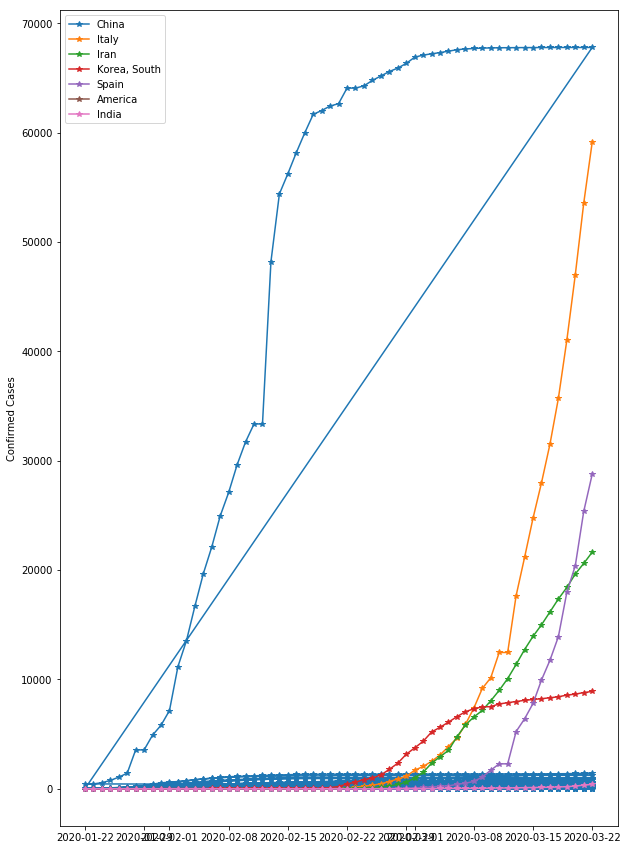

In [62]:
data_train.Date = pd.to_datetime(data_train.Date)
plt.figure(figsize=(10,15))
for country in countries:
    plt.plot(data_train[data_train["Country/Region"] == country].Date,
             data_train[data_train["Country/Region"] == country].ConfirmedCases,
             marker="*", label=country)

plt.legend();
plt.ylabel("Confirmed Cases");

#### Visualizing Fatalities for few countries

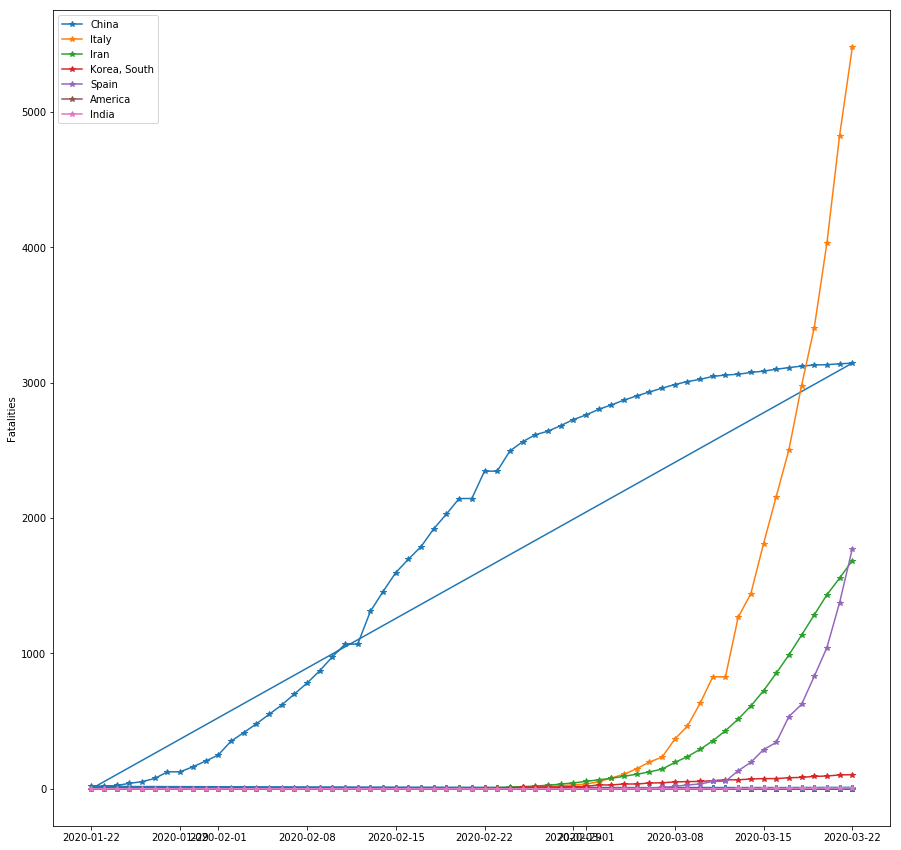

In [63]:
data_train.Date = pd.to_datetime(data_train.Date, cache=True)
plt.figure(figsize=(15,15))
for country in countries:
    plt.plot(data_train[data_train["Country/Region"] == country].Date,
             data_train[data_train["Country/Region"] == country].Fatalities,
             marker="*", label=country)
plt.legend();
plt.ylabel("Fatalities");

## Modeling Time!

## Deploying XGBoost

After using the XGBoost model with a bit of parameter tuning the MLE score was around 0.22650

#### Label Encoding 

In [14]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
for column in data:
    if data[column].dtype == type(object):
        le = LabelEncoder()
        data[column] = le.fit_transform(data[column])


#### One Hot Encoding

In [15]:
onehotencoder = OneHotEncoder(categories = "auto")

#### Separating train and test data values

In [64]:
train_data = data.iloc[:17324]
test_data = data.iloc[17324:]

#### Assigning Matrix of features to X and the training(known) values of ConfirmedCases and Fatalities to two different Y variables(y_cc and y_fat)

In [17]:
X = train_data.values
test = test_data.values
y_cc = confirmed_train.values
y_fat = fatalities_train.values
onehotencoder.fit_transform(X).toarray()
onehotencoder.fit_transform(test).toarray()

array([[0., 0., 0., ..., 1., 1., 0.],
       [0., 0., 0., ..., 1., 1., 0.],
       [0., 0., 0., ..., 1., 1., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 1.],
       [0., 0., 0., ..., 1., 0., 1.],
       [0., 0., 0., ..., 1., 0., 1.]])

#### Using XGBoost with different params on y_cc and y_fat

In [65]:
import xgboost as xgb

In [66]:
xgb1 = xgb.XGBRegressor(n_estimators=95, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)

In [67]:
xgb1.fit(X,y_cc)

[14:16:34] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.08, max_delta_step=0,
       max_depth=7, min_child_weight=1, missing=None, n_estimators=95,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=0.75, verbosity=1)

In [68]:
predictions_cc = xgb1.predict(test)
predictions_cc.astype(int)

array([59, 77, 74, ..., 76, 84, 84])

In [69]:
xgb1.fit(X,y_fat)
predictions_fat = xgb1.predict(test)
predictions_fat.astype(int)

[14:16:35] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


array([0, 1, 1, ..., 0, 0, 0])

#### Adding the obtained columns to the submission file against the 'ForecastId'

In [43]:
submission['ConfirmedCases'] = predictions_cc.astype(int)
submission['Fatalities'] = predictions_fat.astype(int)

In [75]:
submission = submission[['ForecastId','ConfirmedCases','Fatalities']]
submission[submission<0]= 0  #Since few predictions yielded negative values, I have replaced negative values by 0s
submission.head()

,ForecastId,ConfirmedCases,Fatalities
0,1,7,0
1,2,7,0
2,3,11,0
3,4,16,0
4,5,21,0


In [76]:
submission.to_csv('submission.csv', index=False)

## Using RandomForestClassifier

The MLE obtained using RandomForestClassifier was 0.0000 and the result was among the top 6% of the competitors.

In [77]:
from sklearn.ensemble import RandomForestClassifier

In [78]:
rfc_model = RandomForestClassifier(bootstrap=True,max_depth=None, max_features='auto', max_leaf_nodes=None, 
                      n_estimators=150, random_state=None, n_jobs=1, verbose=0)
rfc_model.fit(X,y_cc)
pred_cc = rfc_model.predict(test)


In [79]:
rfc_model.fit(X,y_fat)
pred_fat = rfc_model.predict(test)

In [80]:
submission['ConfirmedCases'] = pred_cc.astype(int)
submission['Fatalities'] = pred_fat.astype(int)

In [81]:
submission = submission[['ForecastId','ConfirmedCases','Fatalities']]
submission[submission<0] = 0
submission.head()

,ForecastId,ConfirmedCases,Fatalities
0,1,7,0
1,2,7,0
2,3,11,0
3,4,16,0
4,5,21,0


In [82]:
submission.to_csv('submission.csv', index=False)